##**Install gymnasium and pygame**

In [ ]:
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install pygame
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Import**

In [ ]:
import gymnasium as gym
import pygame
import random
import collections
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

##**Function for video rendering purpose**<br>

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)

Video Rendering Part Reference :
https://cutt.ly/F3JsIa5

"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

##**Functions for task 2 (Lunar-Lander)**

In [ ]:


def LunarLander_render(env,pol):
    s = env.reset()[0]
    for i in range(1000):
        act = 0
        if state_discrete(tuple(s)) not in pol.keys():
            act = 0
        else :
            act = pol[state_discrete(tuple(s))]
        observation, reward, terminated, truncated = env.step(act)

        env.render()
        if terminated == True:

            break

        s = observation

def render_reward(pol):
    env = env = gym.make("LunarLander-v2",render_mode=None)
    s = env.reset()[0]
    r = 0
    for i in range(1000):
        act = 0
        if state_discrete(tuple(s)) not in pol.keys():
            act = 0
        else :
            act = pol[state_discrete(tuple(s))]
        observation, reward, terminated, truncated,info = env.step(act)
        r += reward
        if terminated == True:
            return r
            break

        s = observation
    return r

def state_discrete(s):

    '''
    Discretization idea
    https://web.stanford.edu/class/aa228/reports/2019/final8.pdf
    '''

    x = min(3, max(-3, int((s[0]) / 0.05)))
    y = min(3, max(-1, int((s[1]) / 0.1)))
    u = min(2, max(-2, int((s[2]) / 0.1)))
    v = min(2, max(-2, int((s[3]) / 0.1)))
    a = min(2, max(-2, int((s[4]) / 0.1)))
    av = min(2, max(-2, int((s[5]) / 0.1)))
    l1 = int(s[6])
    l2 = int(s[7])

    return (x,y,u,v,a,av,l1,l2)


def get_greedy_act(Q,s):
    val = np.array([ val_q_s_a(Q,s,a) for a in [0, 1, 2, 3]])
    return np.argmax(val)

def get_epsilon_greedy_action(Q,s,epsilon):
    rn = np.random.uniform(0,1)
    if rn < epsilon:
      return np.random.randint(0,4)
    else :
      return get_greedy_act(Q,s)

def get_greedy_policy(Q):
  opt_pol = {}
  for (s,a) in list(Q.keys()):
    val = -np.inf
    pol = 0
    for i in range(4):
      if val_q_s_a(Q,s,i) > val:
        val = val_q_s_a(Q,s,i)
        pol = i
    opt_pol[s] = pol
  return opt_pol

def val_q_s_a(Q,s,a):
  if (s,a) in Q:
    return Q[(s,a)]
  else:
    return 0

def sarsa_eps_greedy(env,epsilon=0.1,n_episode=1000,alpha=0.01,gamma=1,print_prog=True):

    rew_per_episode = []
    max_time_step = []
    Q = {}
    for i in range(n_episode):
        if print_prog == True and (i%50 == 0 or i==n_episode-1):
          print('Episode no = {}'.format(i+1))
        s = env.reset()[0]
        s = state_discrete(s)
        a = get_epsilon_greedy_action(Q,s,epsilon)
        sum_reward = 0
        time_step = 0
        while True:
            time_step += 1
            observation, reward, terminated, truncated, info= env.step(a)

            s_prime = state_discrete(observation)
            a_prime = get_epsilon_greedy_action(Q,s_prime,epsilon)

            Q[(s_prime,a_prime)] = val_q_s_a(Q,s_prime,a_prime)

            Q[(s,a)] = val_q_s_a(Q,s,a)
            Q[(s,a)] += alpha*(reward + gamma*Q[(s_prime,a_prime)]-Q[(s,a)])

            s = s_prime
            a = a_prime
            sum_reward += reward
            if terminated == True :
                max_time_step.append(time_step)
                rew_per_episode.append(sum_reward)
                break

    return get_greedy_policy(Q),rew_per_episode,max_time_step


def expected_q_fun(Q,s_prime,epsilon):
  ex_val = 0
  greedy_act = get_greedy_act(Q,s_prime)
  for i in range(4):
    if i == greedy_act:
      ex_val += (1-epsilon)*val_q_s_a(Q,s_prime,i)
    else:
      ex_val += epsilon*val_q_s_a(Q,s_prime,i)/3

  return ex_val


def expected_sarsa_eps_greedy(env,epsilon=0.1,n_episode=1000,alpha=0.01,gamma=1,print_prog=True):

    rew_per_episode = []
    max_time_step = []
    Q = {}

    for i in range(n_episode):
        if print_prog==True and (i%50 == 0 or i==n_episode-1):
          print('Episode no = {}'.format(i+1))
        s = env.reset()[0]
        s = state_discrete(s)

        a = get_epsilon_greedy_action(Q,s,epsilon)
        sum_reward = 0
        time_step = 0
        while True:
            time_step += 1
            observation, reward, terminated, truncated, info= env.step(a)
            s_prime = state_discrete(observation)
            a_prime = get_greedy_act(Q,s_prime)

            expected_next_q = expected_q_fun(Q,s_prime,epsilon)
            Q[(s,a)] = val_q_s_a(Q,s,a)
            Q[(s,a)] += alpha*(reward + gamma*expected_next_q-Q[(s,a)])

            s = s_prime
            a = a_prime
            sum_reward += reward
            if terminated == True:
                max_time_step.append(time_step)
                rew_per_episode.append(sum_reward)
                break

    return get_greedy_policy(Q),rew_per_episode,max_time_step

#**Q1**

##**SARSA**

###**Initial Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_sarsa_100,rew_eps_sarsa_100,max_time_step_100 = sarsa_eps_greedy(env,n_episode=100,alpha=0.01)

Episode no = 1
Episode no = 51
Episode no = 100


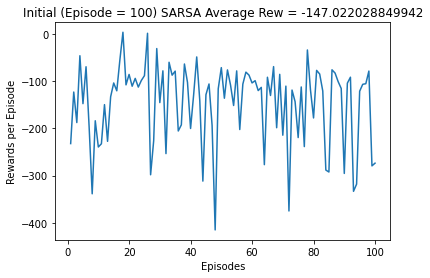

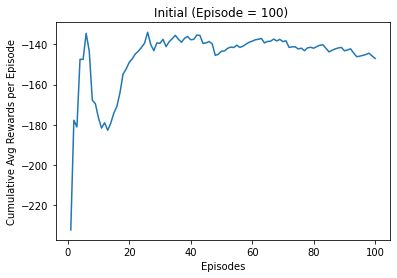

In [ ]:
plt.title('Initial (Episode = 100) SARSA Average Rew = {}'.format(np.mean(rew_eps_sarsa_100)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([i for i in range(1,101)],[rew_eps_sarsa_100[i-1] for i in range(1,101)])
plt.show()

cavg_rew_eps_sarsa_100 = []
sum = 0
for i in range(len(rew_eps_sarsa_100)):
  sum += rew_eps_sarsa_100[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_sarsa_100.append(c_avg)

plt.title('Initial (Episode = 100) ')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([i for i in range(1,101)],[cavg_rew_eps_sarsa_100[i-1] for i in range(1,101)])
plt.show()

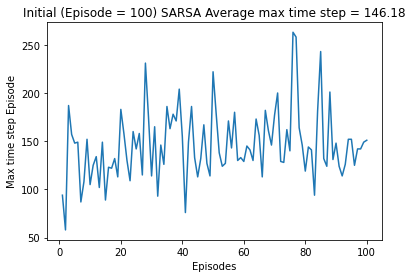

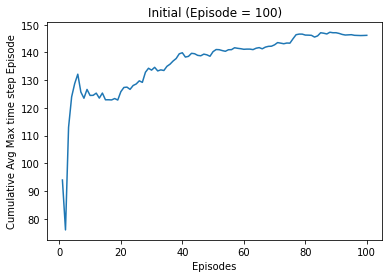

In [ ]:
plt.title('Initial (Episode = 100) SARSA Average max time step = {}'.format(np.mean(max_time_step_100)))
plt.xlabel('Episodes')
plt.ylabel('Max time step Episode')
plt.plot([i for i in range(1,101)],[max_time_step_100[i-1] for i in range(1,101)])
plt.show()

cavg_max_time_step_100 = []
sum = 0
for i in range(len(rew_eps_sarsa_100)):
  sum += max_time_step_100[i]
  c_avg = sum/(i+1)
  cavg_max_time_step_100.append(c_avg)

plt.title('Initial (Episode = 100)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Max time step Episode')
plt.plot([i for i in range(1,101)],[cavg_max_time_step_100[i-1] for i in range(1,101)])
plt.show()

**Render Video for Initial Stage**

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_sarsa_100)
env.close()
show_video()

**Initial Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 10
rew_sarsa_render = []
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_sarsa_100)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
print('Mean Reward for {} episodes = {}'.format(n_ep,mean))

Mean Reward for 10 episodes = -154.55499220826593


###**Mid Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_sarsa_5K,rew_eps_sarsa_5K,max_time_step_5K = sarsa_eps_greedy(env,n_episode=5000,alpha=0.01)

Episode no = 1
Episode no = 51
Episode no = 101
Episode no = 151
Episode no = 201
Episode no = 251
Episode no = 301
Episode no = 351
Episode no = 401
Episode no = 451
Episode no = 501
Episode no = 551
Episode no = 601
Episode no = 651
Episode no = 701
Episode no = 751
Episode no = 801
Episode no = 851
Episode no = 901
Episode no = 951
Episode no = 1001
Episode no = 1051
Episode no = 1101
Episode no = 1151
Episode no = 1201
Episode no = 1251
Episode no = 1301
Episode no = 1351
Episode no = 1401
Episode no = 1451
Episode no = 1501
Episode no = 1551
Episode no = 1601
Episode no = 1651
Episode no = 1701
Episode no = 1751
Episode no = 1801
Episode no = 1851
Episode no = 1901
Episode no = 1951
Episode no = 2001
Episode no = 2051
Episode no = 2101
Episode no = 2151
Episode no = 2201
Episode no = 2251
Episode no = 2301
Episode no = 2351
Episode no = 2401
Episode no = 2451
Episode no = 2501
Episode no = 2551
Episode no = 2601
Episode no = 2651
Episode no = 2701
Episode no = 2751
Episode no = 28

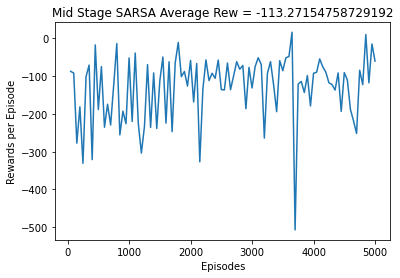

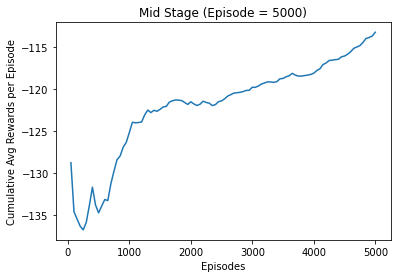

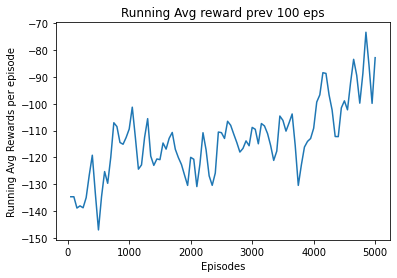

In [ ]:
plt.title('Mid Stage SARSA Average Rew = {}'.format(np.mean(rew_eps_sarsa_5K)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[rew_eps_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

cavg_rew_eps_sarsa_5K = []
sum = 0
for i in range(len(rew_eps_sarsa_5K)):
  sum += rew_eps_sarsa_5K[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_sarsa_5K.append(c_avg)

plt.title('Mid Stage (Episode = 5000)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[cavg_rew_eps_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()


r = 100
ravg_rew_eps_sarsa_5K = pd.DataFrame(rew_eps_sarsa_5K).rolling(r).mean()
ravg_rew_eps_sarsa_5K = np.array(ravg_rew_eps_sarsa_5K)
ravg_rew_eps_sarsa_5K[0:r-1] = ravg_rew_eps_sarsa_5K[r-1]

plt.title('Running Avg reward prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Rewards per episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[ravg_rew_eps_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

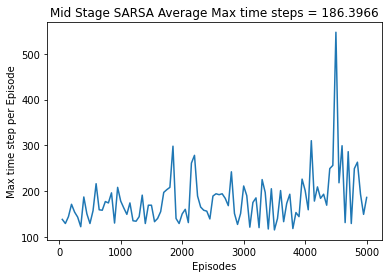

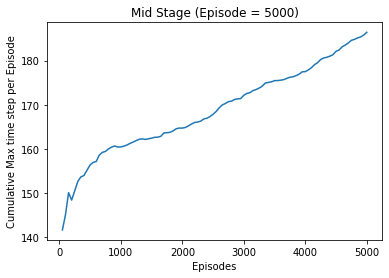

In [ ]:
plt.title('Mid Stage SARSA Average Max time steps = {}'.format(np.mean(max_time_step_5K)))
plt.xlabel('Episodes')
plt.ylabel('Max time step per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[max_time_step_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

cavg_max_time_step_5K = []
sum = 0
for i in range(len(max_time_step_5K)):
  sum += max_time_step_5K[i]
  c_avg = sum/(i+1)
  cavg_max_time_step_5K.append(c_avg)

plt.title('Mid Stage (Episode = 5000)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Max time step per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[cavg_max_time_step_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()



**Render Video for Mid Stage**

In [ ]:
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env,pol_sarsa_5K)
env.close()
show_video()

**Mid Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 10
rew_sarsa_render = []
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_sarsa_5K)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
std = np.std(rew_sarsa_render)
print('Mean Reward for {} rendering episodes = {}'.format(n_ep,mean))

Mean Reward for 10 rendering episodes = -158.75805450385207


###**Final Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_sarsa_20K,rew_eps_sarsa_20K,max_time_step_20K = sarsa_eps_greedy(env,n_episode=20000,alpha=0.01)
np.save('pol_sarsa_20K.npy',pol_sarsa_20K)

Episode no = 1
Episode no = 51
Episode no = 101
Episode no = 151
Episode no = 201
Episode no = 251
Episode no = 301
Episode no = 351
Episode no = 401
Episode no = 451
Episode no = 501
Episode no = 551
Episode no = 601
Episode no = 651
Episode no = 701
Episode no = 751
Episode no = 801
Episode no = 851
Episode no = 901
Episode no = 951
Episode no = 1001
Episode no = 1051
Episode no = 1101
Episode no = 1151
Episode no = 1201
Episode no = 1251
Episode no = 1301
Episode no = 1351
Episode no = 1401
Episode no = 1451
Episode no = 1501
Episode no = 1551
Episode no = 1601
Episode no = 1651
Episode no = 1701
Episode no = 1751
Episode no = 1801
Episode no = 1851
Episode no = 1901
Episode no = 1951
Episode no = 2001
Episode no = 2051
Episode no = 2101
Episode no = 2151
Episode no = 2201
Episode no = 2251
Episode no = 2301
Episode no = 2351
Episode no = 2401
Episode no = 2451
Episode no = 2501
Episode no = 2551
Episode no = 2601
Episode no = 2651
Episode no = 2701
Episode no = 2751
Episode no = 28

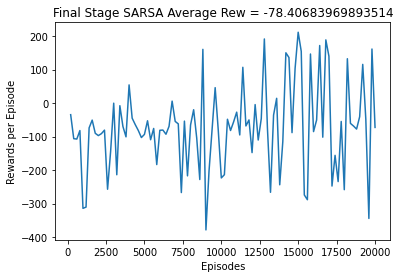

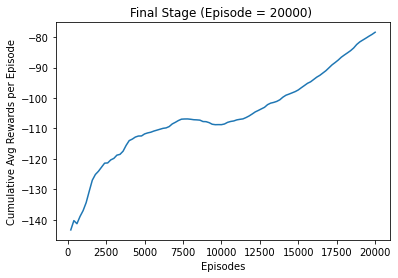

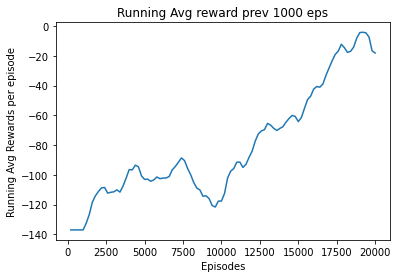

In [ ]:
plt.title('Final Stage SARSA Average Rew = {}'.format(np.mean(rew_eps_sarsa_20K)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[rew_eps_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

cavg_rew_eps_sarsa_20K = []
sum = 0
for i in range(len(rew_eps_sarsa_20K)):
  sum += rew_eps_sarsa_20K[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_sarsa_20K.append(c_avg)

plt.title('Final Stage (Episode = 20000) ')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[cavg_rew_eps_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

r = 1000
ravg_rew_eps_sarsa_20K = pd.DataFrame(rew_eps_sarsa_20K).rolling(r).mean()
ravg_rew_eps_sarsa_20K = np.array(ravg_rew_eps_sarsa_20K)
ravg_rew_eps_sarsa_20K[0:r-1] = ravg_rew_eps_sarsa_20K[r-1]

plt.title('Running Avg reward prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Rewards per episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[ravg_rew_eps_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

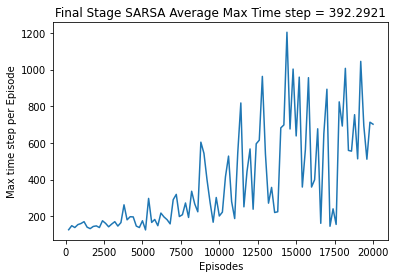

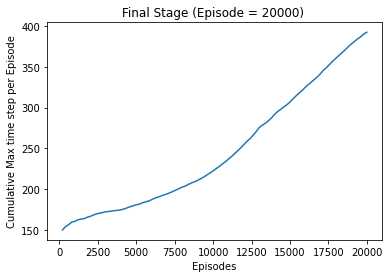

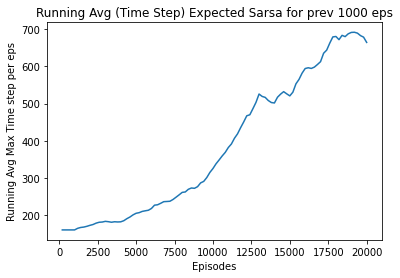

In [ ]:
plt.title('Final Stage SARSA Average Max Time step = {}'.format(np.mean(max_time_step_20K)))
plt.xlabel('Episodes')
plt.ylabel('Max time step per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[max_time_step_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

cavg_max_time_step_20K = []
sum = 0
for i in range(len(max_time_step_20K)):
  sum += max_time_step_20K[i]
  c_avg = sum/(i+1)
  cavg_max_time_step_20K.append(c_avg)

plt.title('Final Stage (Episode = 20000) ')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Max time step per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[cavg_max_time_step_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

r = 1000
ravg_max_time_step_20K = pd.DataFrame(max_time_step_20K).rolling(r).mean()
ravg_max_time_step_20K = np.array(ravg_max_time_step_20K)
ravg_max_time_step_20K[0:r-1] = ravg_max_time_step_20K[r-1]

plt.title('Running Avg (Time Step) Expected Sarsa for prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Max Time step per eps')
plt.plot([max(200*i-1,0) for i in range(1,101)],[ravg_max_time_step_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

**Final Stage Render Video**

In [ ]:
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env,pol_sarsa_20K)
env.close()
show_video()

**Final Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 10
rew_sarsa_render = []
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_sarsa_20K)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
std = np.std(rew_sarsa_render)
print('Mean Reward for {} rendering episodes = {}'.format(n_ep,mean))

Mean Reward for 10 rendering episodes = 16.19065113245995


##**Expected SARSA**

###**Initial Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_expected_sarsa_100,rew_eps_expected_sarsa_100,exp_max_time_step_100 = expected_sarsa_eps_greedy(env,epsilon=0.1,n_episode=100,alpha=0.01)

Episode no = 1
Episode no = 51
Episode no = 100


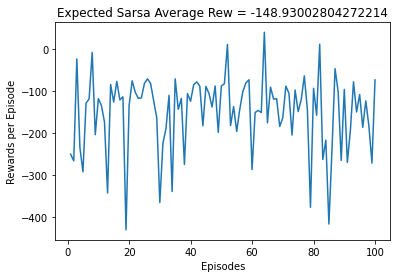

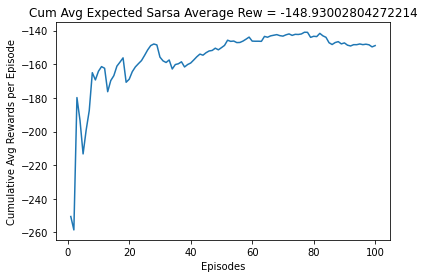

In [ ]:
plt.title('Expected Sarsa Average Rew = {}'.format(np.mean(rew_eps_expected_sarsa_100)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([i for i in range(1,101)],[rew_eps_expected_sarsa_100[i-1] for i in range(1,101)])
plt.show()

cavg_rew_eps_expected_sarsa_100 = []
sum = 0
for i in range(len(rew_eps_expected_sarsa_100)):
  sum += rew_eps_expected_sarsa_100[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_expected_sarsa_100.append(c_avg)

plt.title('Cum Avg Expected Sarsa Average Rew = {}'.format(np.mean(rew_eps_expected_sarsa_100)))
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([i for i in range(1,101)],[cavg_rew_eps_expected_sarsa_100[i-1] for i in range(1,101)])

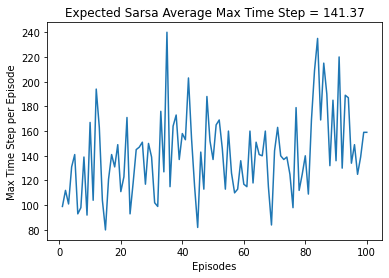

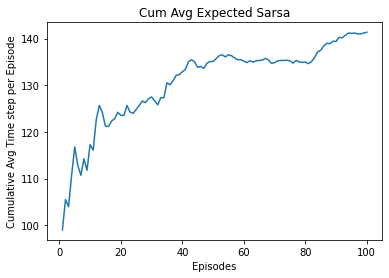

In [ ]:
plt.title('Expected Sarsa Average Max Time Step = {}'.format(np.mean(exp_max_time_step_100)))
plt.xlabel('Episodes')
plt.ylabel('Max Time Step per Episode')
plt.plot([i for i in range(1,101)],[exp_max_time_step_100[i-1] for i in range(1,101)])
plt.show()

cavg_exp_max_time_step_100 = []
sum = 0
for i in range(len(exp_max_time_step_100)):
  sum += exp_max_time_step_100[i]
  c_avg = sum/(i+1)
  cavg_exp_max_time_step_100.append(c_avg)

plt.title('Cum Avg Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Time step per Episode')
plt.plot([i for i in range(1,101)],[cavg_exp_max_time_step_100[i-1] for i in range(1,101)])

**Render Video for Initial Stage**

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_expected_sarsa_100)
env.close()
show_video()

**Initial Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 50
rew_sarsa_render = []
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_expected_sarsa_100)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
std = np.std(rew_sarsa_render)
print('Mean Reward for {} episodes = {}'.format(n_ep,mean))

Mean Reward for 50 episodes = -257.9265234455868


###**Mid Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_expected_sarsa_5K,rew_eps_expected_sarsa_5K,max_time_step_exp_5K = expected_sarsa_eps_greedy(env,epsilon=0.1,n_episode=5000,alpha=0.01)

Episode no = 1
Episode no = 51
Episode no = 101
Episode no = 151
Episode no = 201
Episode no = 251
Episode no = 301
Episode no = 351
Episode no = 401
Episode no = 451
Episode no = 501
Episode no = 551
Episode no = 601
Episode no = 651
Episode no = 701
Episode no = 751
Episode no = 801
Episode no = 851
Episode no = 901
Episode no = 951
Episode no = 1001
Episode no = 1051
Episode no = 1101
Episode no = 1151
Episode no = 1201
Episode no = 1251
Episode no = 1301
Episode no = 1351
Episode no = 1401
Episode no = 1451
Episode no = 1501
Episode no = 1551
Episode no = 1601
Episode no = 1651
Episode no = 1701
Episode no = 1751
Episode no = 1801
Episode no = 1851
Episode no = 1901
Episode no = 1951
Episode no = 2001
Episode no = 2051
Episode no = 2101
Episode no = 2151
Episode no = 2201
Episode no = 2251
Episode no = 2301
Episode no = 2351
Episode no = 2401
Episode no = 2451
Episode no = 2501
Episode no = 2551
Episode no = 2601
Episode no = 2651
Episode no = 2701
Episode no = 2751
Episode no = 28

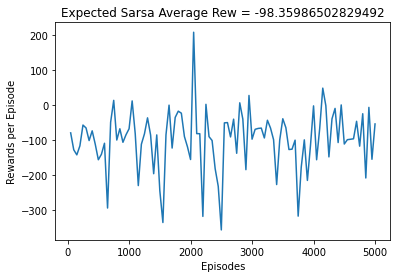

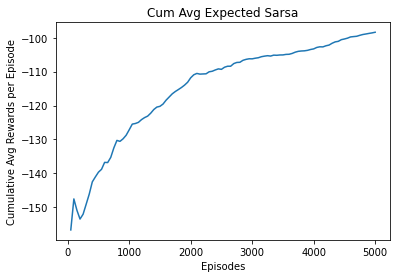

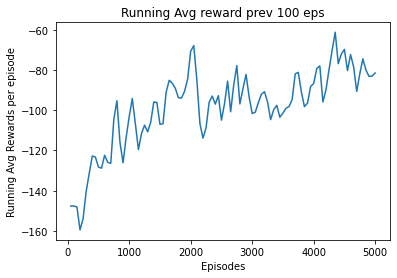

In [ ]:
plt.title('Expected Sarsa Average Rew = {}'.format(np.mean(rew_eps_expected_sarsa_5K)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[rew_eps_expected_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

cavg_rew_eps_expected_sarsa_5K = []
sum = 0
for i in range(len(rew_eps_expected_sarsa_5K)):
  sum += rew_eps_expected_sarsa_5K[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_expected_sarsa_5K.append(c_avg)

plt.title('Cum Avg Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[cavg_rew_eps_expected_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

r = 100
ravg_rew_eps_expected_sarsa_5K = pd.DataFrame(rew_eps_expected_sarsa_5K).rolling(r).mean()
ravg_rew_eps_expected_sarsa_5K = np.array(ravg_rew_eps_expected_sarsa_5K)
ravg_rew_eps_expected_sarsa_5K[0:r-1] = ravg_rew_eps_expected_sarsa_5K[r-1]

plt.title('Running Avg reward prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Rewards per episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[ravg_rew_eps_expected_sarsa_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

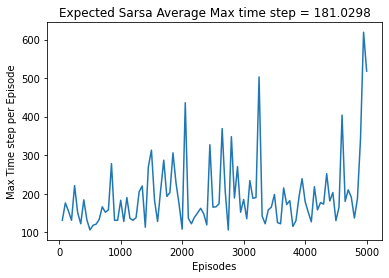

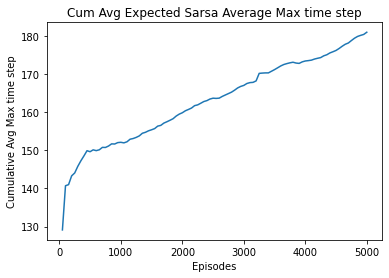

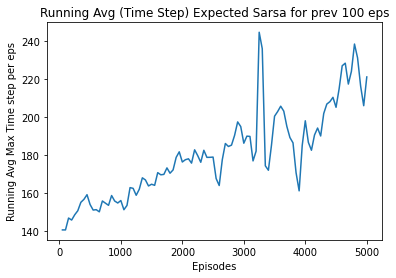

In [ ]:
plt.title('Expected Sarsa Average Max time step = {}'.format(np.mean(max_time_step_exp_5K)))
plt.xlabel('Episodes')
plt.ylabel('Max Time step per Episode')
plt.plot([max(50*i-1,0) for i in range(1,101)],[max_time_step_exp_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

cavg_exp_max_time_step_5K = []
sum = 0
for i in range(len(max_time_step_exp_5K)):
  sum += max_time_step_exp_5K[i]
  c_avg = sum/(i+1)
  cavg_exp_max_time_step_5K.append(c_avg)

plt.title('Cum Avg Expected Sarsa Average Max time step')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Max time step')
plt.plot([max(50*i-1,0) for i in range(1,101)],[cavg_exp_max_time_step_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

r = 100
ravg_max_time_step_exp_5K = pd.DataFrame(max_time_step_exp_5K).rolling(r).mean()
ravg_max_time_step_exp_5K = np.array(ravg_max_time_step_exp_5K)
ravg_max_time_step_exp_5K[0:r-1] = ravg_max_time_step_exp_5K[r-1]

plt.title('Running Avg (Time Step) Expected Sarsa for prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Max Time step per eps')
plt.plot([max(50*i-1,0) for i in range(1,101)],[ravg_max_time_step_exp_5K[max(50*i-1,0)] for i in range(1,101)])
plt.show()

**Render Video for Mid Stage**

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_expected_sarsa_5K)
env.close()
show_video()

**Mid Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 50
rew_sarsa_render = []
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_expected_sarsa_5K)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
std = np.std(rew_sarsa_render)
print('Mean Reward for {} episodes = {}'.format(n_ep,mean))

Mean Reward for 50 episodes = -94.81081083278612


###**Final Stage**

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_expected_sarsa_20K,rew_eps_expected_sarsa_20K,max_time_step_exp_20K = expected_sarsa_eps_greedy(env,epsilon=0.1,n_episode=20000,alpha=0.01)
np.save('pol_expected_sarsa_20K.npy',pol_expected_sarsa_20K)

Episode no = 1
Episode no = 51
Episode no = 101
Episode no = 151
Episode no = 201
Episode no = 251
Episode no = 301
Episode no = 351
Episode no = 401
Episode no = 451
Episode no = 501
Episode no = 551
Episode no = 601
Episode no = 651
Episode no = 701
Episode no = 751
Episode no = 801
Episode no = 851
Episode no = 901
Episode no = 951
Episode no = 1001
Episode no = 1051
Episode no = 1101
Episode no = 1151
Episode no = 1201
Episode no = 1251
Episode no = 1301
Episode no = 1351
Episode no = 1401
Episode no = 1451
Episode no = 1501
Episode no = 1551
Episode no = 1601
Episode no = 1651
Episode no = 1701
Episode no = 1751
Episode no = 1801
Episode no = 1851
Episode no = 1901
Episode no = 1951
Episode no = 2001
Episode no = 2051
Episode no = 2101
Episode no = 2151
Episode no = 2201
Episode no = 2251
Episode no = 2301
Episode no = 2351
Episode no = 2401
Episode no = 2451
Episode no = 2501
Episode no = 2551
Episode no = 2601
Episode no = 2651
Episode no = 2701
Episode no = 2751
Episode no = 28

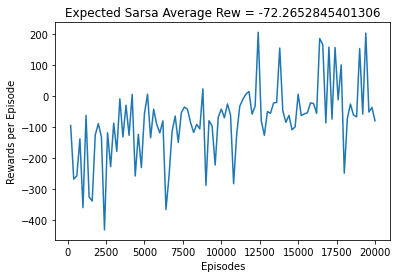

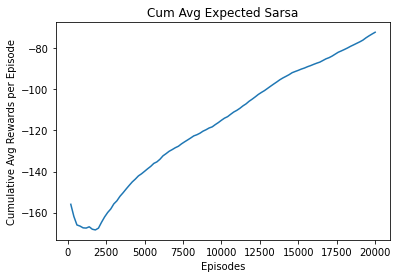

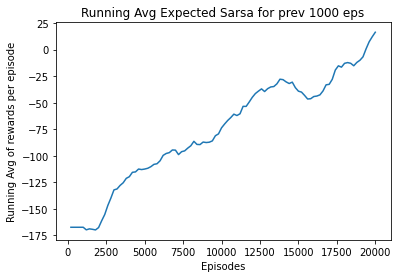

In [ ]:
plt.title('Expected Sarsa Average Rew = {}'.format(np.mean(rew_eps_expected_sarsa_20K)))
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[rew_eps_expected_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

cavg_rew_eps_expected_sarsa_20K = []
sum = 0
for i in range(len(rew_eps_expected_sarsa_20K)):
  sum += rew_eps_expected_sarsa_20K[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_expected_sarsa_20K.append(c_avg)

plt.title('Cum Avg Expected Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[cavg_rew_eps_expected_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

r = 1000
ravg_rew_eps_expected_sarsa_20K = pd.DataFrame(rew_eps_expected_sarsa_20K).rolling(r).mean()
ravg_rew_eps_expected_sarsa_20K = np.array(ravg_rew_eps_expected_sarsa_20K)
ravg_rew_eps_expected_sarsa_20K[0:r-1] = ravg_rew_eps_expected_sarsa_20K[r-1]

plt.title('Running Avg Expected Sarsa for prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg of rewards per episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[ravg_rew_eps_expected_sarsa_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

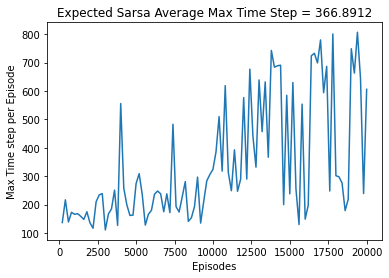

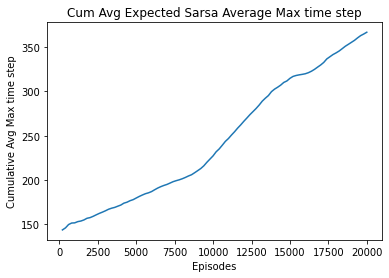

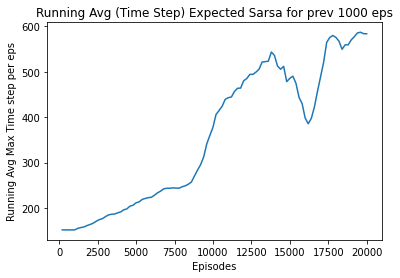

In [ ]:
plt.title('Expected Sarsa Average Max Time Step = {}'.format(np.mean(max_time_step_exp_20K)))
plt.xlabel('Episodes')
plt.ylabel('Max Time step per Episode')
plt.plot([max(200*i-1,0) for i in range(1,101)],[max_time_step_exp_20K[max(200*i-1,0)] for i in range(1,101)])

plt.show()

cavg_max_time_step_exp_20K = []
sum = 0
for i in range(len(max_time_step_exp_20K)):
  sum += max_time_step_exp_20K[i]
  c_avg = sum/(i+1)
  cavg_max_time_step_exp_20K.append(c_avg)

plt.title('Cum Avg Expected Sarsa Average Max time step')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Max time step')
plt.plot([max(200*i-1,0) for i in range(1,101)],[cavg_max_time_step_exp_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

r = 1000
ravg_max_time_step_exp_20K = pd.DataFrame(max_time_step_exp_20K).rolling(r).mean()
ravg_max_time_step_exp_20K = np.array(ravg_max_time_step_exp_20K)
ravg_max_time_step_exp_20K[0:r-1] = ravg_max_time_step_exp_20K[r-1]

plt.title('Running Avg (Time Step) Expected Sarsa for prev {} eps'.format(r))
plt.xlabel('Episodes')
plt.ylabel('Running Avg Max Time step per eps')
plt.plot([max(200*i-1,0) for i in range(1,101)],[ravg_max_time_step_exp_20K[max(200*i-1,0)] for i in range(1,101)])
plt.show()

**Render Video for Final Stage**

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_expected_sarsa_20K)
env.close()
show_video()

**Final Stage Average Render Reward (Score)**

In [ ]:
tot_rew = 0
j = 0
n_ep = 10
rew_sarsa_render = []
env = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
for i in range(n_ep):
    j += 1
    rew = render_reward(pol_expected_sarsa_20K)
    rew_sarsa_render.append(rew)

mean = np.mean(rew_sarsa_render)
print('Mean Reward for {} rendering episodes = {}'.format(n_ep,mean))

Mean Reward for 10 rendering episodes = 80.475124499204


#**Observations Q1**<br>


It can be seen that with increase in number of episodes, the average sum of rewards earned increases which means that agent is learning with episodes in **sarsa** as well as in **expected sarsa**.<br>
Also,It can be seen that as the number of episodes increases, the max time step also increases.<br>
Higher max time step indicates higher stability in air which implies that with increase in number of episodes the agent is learning better policy.<br>
<br>
Also, both the methods is able to give **Successful** policy in around 20K episodes.<br>
<br>
The Cumulative average reward curve of Expected-sarsa increases at almost constant rate whereas in the case of sarsa it fluctuates more.
This is probably due to the fact that expected sarsa eliminates variance.
<br>
**comparison**:
<br>
Initially **SARSA** learns better, but after some episodes of training (roughly 5K ), **Expected SARSA** starts performing better.

#**Q2**

###**SARSA**

In [ ]:
alpha = [0.0005,0.005,0.01,0.1]
epsilon = [0.9, 0.5, 0.3, 0.1]


Running for alpha = 0.0005, epsilon = 0.9
Mean Render Score = -307.287, std = 110.216

Running for alpha = 0.0005, epsilon = 0.5
Mean Render Score = -315.018, std = 86.319

Running for alpha = 0.0005, epsilon = 0.3
Mean Render Score = -149.886, std = 87.147

Running for alpha = 0.0005, epsilon = 0.1
Mean Render Score = -199.894, std = 81.141


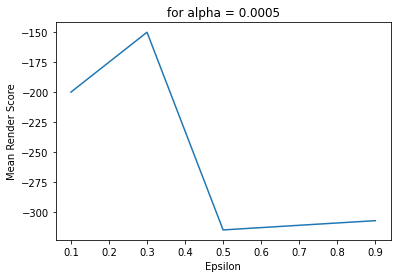

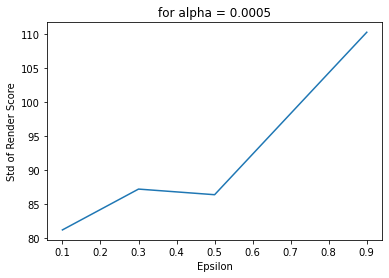


Running for alpha = 0.005, epsilon = 0.9
Mean Render Score = -154.823, std = 127.727

Running for alpha = 0.005, epsilon = 0.5
Mean Render Score = -168.825, std = 58.35

Running for alpha = 0.005, epsilon = 0.3
Mean Render Score = -287.814, std = 234.981

Running for alpha = 0.005, epsilon = 0.1
Mean Render Score = -120.65, std = 31.837


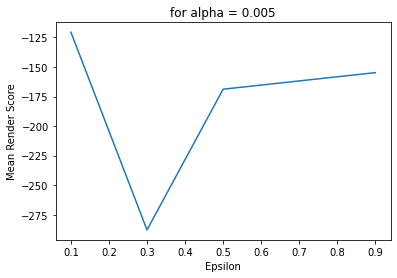

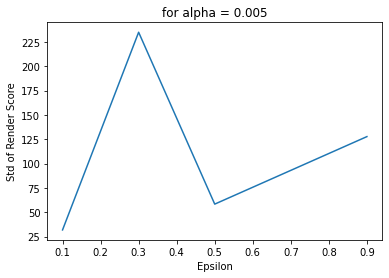


Running for alpha = 0.01, epsilon = 0.9
Mean Render Score = -148.391, std = 41.567

Running for alpha = 0.01, epsilon = 0.5
Mean Render Score = -230.121, std = 152.16

Running for alpha = 0.01, epsilon = 0.3
Mean Render Score = -122.886, std = 66.971

Running for alpha = 0.01, epsilon = 0.1
Mean Render Score = -160.397, std = 77.983


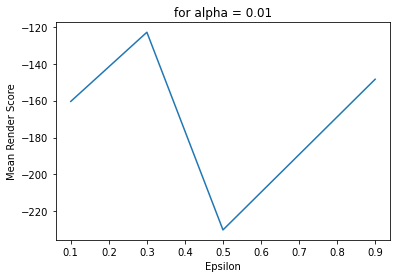

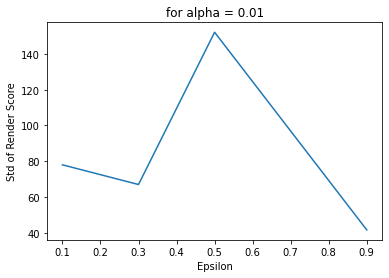


Running for alpha = 0.1, epsilon = 0.9
Mean Render Score = -191.35, std = 66.695

Running for alpha = 0.1, epsilon = 0.5
Mean Render Score = -240.867, std = 82.697

Running for alpha = 0.1, epsilon = 0.3
Mean Render Score = -141.015, std = 113.454

Running for alpha = 0.1, epsilon = 0.1
Mean Render Score = -219.874, std = 101.221


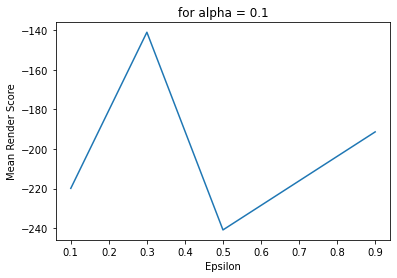

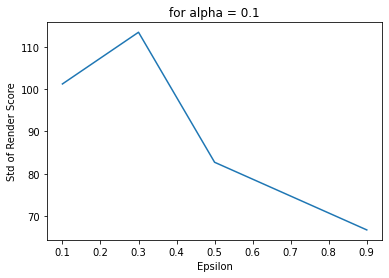

In [ ]:
def render_avg(pol):
  tot_rew = 0
  j = 0
  n_ep = 10
  rew_sarsa_render = []
  for i in range(n_ep):
      j += 1
      rew = render_reward(pol)
      rew_sarsa_render.append(rew)
  mean = np.mean(rew_sarsa_render)
  std = np.std(rew_sarsa_render)
  return np.round(mean,3),np.round(std,3)

for a in alpha:
  mean_score_list = []
  std_score_list = []
  for e in epsilon:
    print('\nRunning for alpha = {}, epsilon = {}'.format(a,e))
    env = gym.make("LunarLander-v2",render_mode=None)
    pol_sarsa,rew_eps_sarsa,max_time_step = sarsa_eps_greedy(env,n_episode=50,alpha=a,epsilon=e,print_prog=False)
    mean = render_avg(pol_sarsa)[0]
    std = render_avg(pol_sarsa)[1]
    mean_score_list.append(mean)
    std_score_list.append(std)
    print('Mean Render Score = {}, std = {}'.format(mean,std))
  plt.title('for alpha = {}'.format(a))
  plt.xlabel('Epsilon')
  plt.ylabel('Mean Render Score')
  plt.plot(epsilon,mean_score_list)
  plt.show()

  plt.title('for alpha = {}'.format(a))
  plt.xlabel('Epsilon')
  plt.ylabel('Std of Render Score')
  plt.plot(epsilon,std_score_list)
  plt.show()

In [ ]:
# From graph it can be seen that overall (avg and std) favours alpha = 0.01 and epsilon = 0.1
# Note : This may vary upon re-running program because rendering involves randomization.
a_op = 0.01
e_op = 0.1
# pol_sarsa_op,rew_eps_sarsa_op,max_time_step_op = sarsa_eps_greedy(env,n_episode=1000,alpha=a_op,epsilon=e_op,print_prog=True)
# So due to epsilon = 0.1 and alpha = 0.01, this is exactly the case as Q1
# so the optimal policy will be same as optimal policy of Final stage Q1
pol_sarsa_op = pol_sarsa_20K

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_sarsa_op)
env.close()
show_video()

###**Expected SARSA**

In [ ]:
alpha = [0.0005,0.005,0.01,0.1]
epsilon = [0.9, 0.5, 0.3, 0.1]


Running for alpha = 0.0005, epsilon = 0.9
Mean Render Score = -264.277, std = 60.599

Running for alpha = 0.0005, epsilon = 0.5
Mean Render Score = -194.809, std = 47.725

Running for alpha = 0.0005, epsilon = 0.3
Mean Render Score = -203.376, std = 69.571

Running for alpha = 0.0005, epsilon = 0.1
Mean Render Score = -187.553, std = 57.728


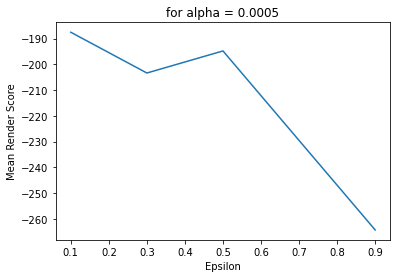

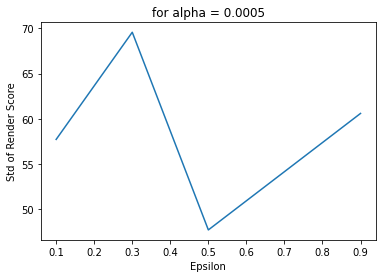


Running for alpha = 0.005, epsilon = 0.9
Mean Render Score = -152.468, std = 79.81

Running for alpha = 0.005, epsilon = 0.5
Mean Render Score = -137.717, std = 173.44

Running for alpha = 0.005, epsilon = 0.3
Mean Render Score = -161.276, std = 59.25

Running for alpha = 0.005, epsilon = 0.1
Mean Render Score = -198.394, std = 85.982


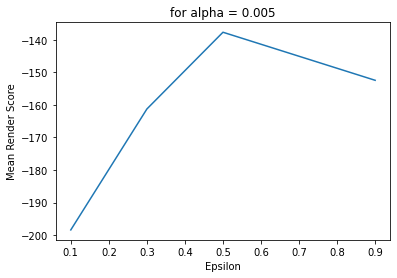

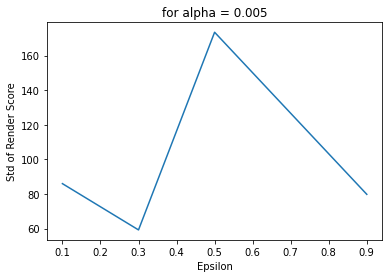


Running for alpha = 0.01, epsilon = 0.9
Mean Render Score = -130.606, std = 83.611

Running for alpha = 0.01, epsilon = 0.5
Mean Render Score = -240.508, std = 131.548

Running for alpha = 0.01, epsilon = 0.3
Mean Render Score = -202.03, std = 121.388

Running for alpha = 0.01, epsilon = 0.1
Mean Render Score = -160.835, std = 43.708


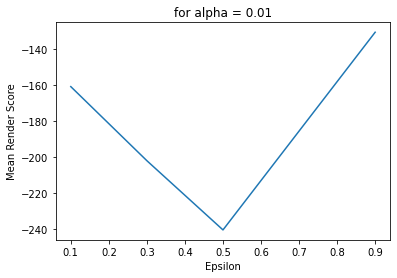

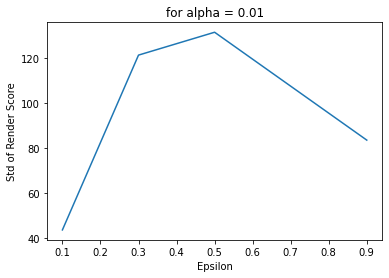


Running for alpha = 0.1, epsilon = 0.9
Mean Render Score = -156.739, std = 20.625

Running for alpha = 0.1, epsilon = 0.5
Mean Render Score = -178.476, std = 61.387

Running for alpha = 0.1, epsilon = 0.3
Mean Render Score = -180.434, std = 87.385

Running for alpha = 0.1, epsilon = 0.1
Mean Render Score = -167.918, std = 18.423


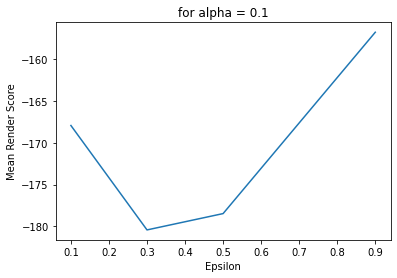

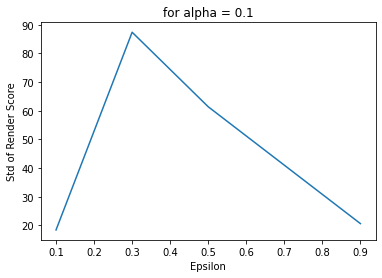

In [ ]:
def render_avg(pol):
  tot_rew = 0
  j = 0
  n_ep = 10
  rew_e_sarsa_render = []
  for i in range(n_ep):
      j += 1
      rew = render_reward(pol)
      rew_e_sarsa_render.append(rew)
  mean = np.mean(rew_e_sarsa_render)
  std = np.std(rew_e_sarsa_render)
  return np.round(mean,3),np.round(std,3)

for a in alpha:
  mean_score_list = []
  std_score_list = []
  for e in epsilon:
    print('\nRunning for alpha = {}, epsilon = {}'.format(a,e))
    env = gym.make("LunarLander-v2",render_mode=None)
    pol_e_sarsa,rew_eps_e_sarsa,max_time_step_e = expected_sarsa_eps_greedy(env,n_episode=20,alpha=a,epsilon=e,print_prog=False)
    mean = render_avg(pol_e_sarsa)[0]
    std = render_avg(pol_e_sarsa)[1]
    mean_score_list.append(mean)
    std_score_list.append(std)
    print('Mean Render Score = {}, std = {}'.format(mean,std))
  plt.title('for alpha = {}'.format(a))
  plt.xlabel('Epsilon')
  plt.ylabel('Mean Render Score')
  plt.plot(epsilon,mean_score_list)
  plt.show()

  plt.title('for alpha = {}'.format(a))
  plt.xlabel('Epsilon')
  plt.ylabel('Std of Render Score')
  plt.plot(epsilon,std_score_list)
  plt.show()

In [ ]:
# From above graph and values, we can say that in expacted sarsa case the optimal
# alpha = 0.01 and epsilon = 0.1
# Note : This value may change if the program is re-run due to randomization in rendering
# I am taking values corresponding to values i got while writing this
a_op_ = 0.01
e_op_ = 0.1

# So, i am taking corresponding policy caclulated in prev ques
pol_e_sarsa_op = pol_expected_sarsa_20K

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_e_sarsa_op)
env.close()
show_video()

#**Observations Q2**

**Comment Q2**<br>
**Effect of changing alpha and epsilon :**<br>
I observed by doing experiment (Not attaching those (experimental) cells to ensure that code in assignment remains to the point ), that as alpha increases the performance also increases but after a certain value it starts performing worse. And as epsilon increases it starts more exploration and runtime increases. So, intermediate value of epsilon usually tends to perform better.<br><br>
**NOTE :** The optimal combination of alpha and beta has been decided based on average and variance of rewards collected in rendering policy corresponding to alpha and beta. Because the rendering has randomization (wind,etc) they may change if the program is **run again**

#**Q3**

In [ ]:
epsilon3 = 0.1
alpha3 = 0.01

def val_e_s_a(e,s,a):
  if (s,a) in e:
    return e[(s,a)]
  else:
    return 0


def sarsa_lambda_eps_greedy(env,epsilon=0.1,n_episode=1000,alpha=0.01,gamma=1,lembda=0.5,print_prog=True):

    rew_per_episode = []
    max_time_step = []
    Q = {}
    e = {}
    for i in range(n_episode):
        if print_prog == True and (i%50 == 0 or i==n_episode-1):
          print('Episode no = {}'.format(i+1))
        s = env.reset()[0]
        s = state_discrete(s)
        a = get_epsilon_greedy_action(Q,s,epsilon)

        cur_eps_s_a = []
        cur_eps_s_a.append((s,a))

        sum_reward = 0
        time_step = 0
        while True:
            time_step += 1
            observation, reward, terminated, truncated, info= env.step(a)

            s_prime = state_discrete(observation)
            a_prime = get_epsilon_greedy_action(Q,s_prime,epsilon)

            Q[(s_prime,a_prime)] = val_q_s_a(Q,s_prime,a_prime)
            Q[(s,a)] = val_q_s_a(Q,s,a)

            delta = reward + gamma*Q[(s_prime,a_prime)] - Q[(s,a)]
            e[(s,a)] = val_e_s_a(e,s,a) + 1

            for (s1,a1) in Q:
              Q[(s1,a1)] += alpha*delta*val_e_s_a(e,s1,a1)
              e[(s1,a1)] = gamma*lembda*val_e_s_a(e,s1,a1)

            s = s_prime
            a = a_prime
            sum_reward += reward
            if terminated == True :
                max_time_step.append(time_step)
                rew_per_episode.append(sum_reward)
                break

    return get_greedy_policy(Q),rew_per_episode,max_time_step

In [ ]:
env = gym.make("LunarLander-v2",render_mode=None)
pol_sarsa_lambda,rew_eps_sarsa_lambda,max_time_step_lambda = sarsa_lambda_eps_greedy(env,n_episode=500,alpha=0.01,epsilon=0.1)

Episode no = 1
Episode no = 51
Episode no = 101
Episode no = 151
Episode no = 201
Episode no = 251
Episode no = 301
Episode no = 351
Episode no = 401
Episode no = 451
Episode no = 500


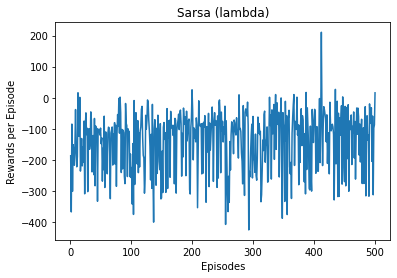

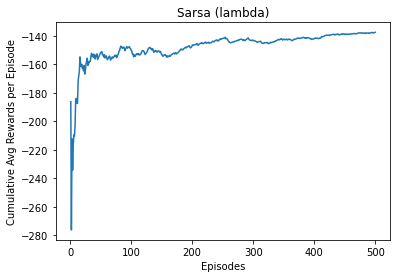

In [ ]:
plt.title('Sarsa (lambda)')
plt.xlabel('Episodes')
plt.ylabel('Rewards per Episode')
plt.plot([i for i in range(1,501)],[rew_eps_sarsa_lambda[i-1] for i in range(1,501)])
plt.show()

cavg_rew_eps_sarsa_lambda = []
sum = 0
for i in range(len(rew_eps_sarsa_lambda)):
  sum += rew_eps_sarsa_lambda[i]
  c_avg = sum/(i+1)
  cavg_rew_eps_sarsa_lambda.append(c_avg)

plt.title('Sarsa (lambda)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Rewards per Episode')
plt.plot([i for i in range(1,501)],[cavg_rew_eps_sarsa_lambda[i-1] for i in range(1,501)])
plt.show()

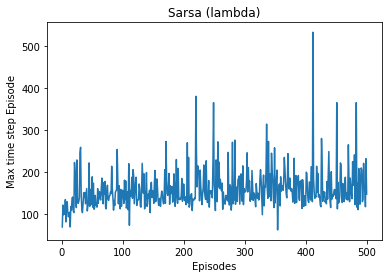

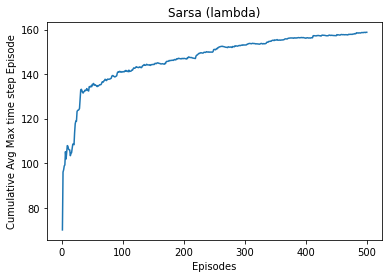

In [ ]:
plt.title('Sarsa (lambda)')
plt.xlabel('Episodes')
plt.ylabel('Max time step Episode')
plt.plot([i for i in range(1,501)],[max_time_step_lambda[i-1] for i in range(1,501)])
plt.show()

cavg_max_time_step_lambda = []
sum = 0
for i in range(len(max_time_step_lambda)):
  sum += max_time_step_lambda[i]
  c_avg = sum/(i+1)
  cavg_max_time_step_lambda.append(c_avg)

plt.title('Sarsa (lambda)')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Avg Max time step Episode')
plt.plot([i for i in range(1,501)],[cavg_max_time_step_lambda[i-1] for i in range(1,501)])
plt.show()

In [ ]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
LunarLander_render(env1,pol_sarsa_lambda)
env.close()
show_video()

# **Q3 Observations**

We can see above that after 500 episodes of training SARSA lambda (lambda = 0.5), is not able to give good policy.<br>
**NOTE** : 500 episodes of sarsa (lambda=0.5) took 20 minutes whereas For plain sarsa the time is around 15 seconds. This is due to the fact that, in case of sarsa lambda, in each step of episodes the Q values for all pairs of (s,a) is updated , whereas in plain sarsa only the Q value of current pair is updated.
<br>
Hence, overall we can say that in this case, the plain SARSA is performing better that SARSA lambda (lambda=0.5).